In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight


df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)

X = df.drop(columns=['defects'])
y = df['defects']


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
table1_results = []
table2_results = []

for ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
    X_train_labeled, X_unlabeled, y_train_labeled, y_unlabeled = train_test_split(
        X_train, y_train, test_size=(1 - ratio), stratify=y_train, random_state=42)
    
    smote = SMOTE(sampling_strategy=0.6, random_state=42)
    X_train_labeled, y_train_labeled = smote.fit_resample(X_train_labeled, y_train_labeled)

    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_labeled), y=y_train_labeled)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    rf = RandomForestClassifier(n_estimators=200, max_depth=12, class_weight=class_weight_dict, random_state=42)
    rf.fit(X_train_labeled, y_train_labeled)
    supervised_acc = accuracy_score(y_test, rf.predict(X_test))

    # Self-training
    thresholds = [0.85, 0.75, 0.65, 0.6]
    max_semi_acc, min_semi_acc, avg_semi_acc = 0, 1, []
    
    for threshold in thresholds:
        X_train_final, y_train_final = X_train_labeled.copy(), y_train_labeled.copy()
        X_unlabeled_copy = X_unlabeled.copy()
        
        for _ in range(10):
            probs = rf.predict_proba(X_unlabeled_copy)
            max_probs = np.max(probs, axis=1)
            pseudo_labels = np.argmax(probs, axis=1)
            
            high_confidence_idx = np.where(max_probs >= threshold)[0]
            if len(high_confidence_idx) == 0:
                break
            
            X_train_final = pd.concat([pd.DataFrame(X_train_final, columns=X.columns), X_unlabeled_copy.iloc[high_confidence_idx]], ignore_index=True)
            y_train_final = np.concatenate((y_train_final, pseudo_labels[high_confidence_idx]))
            
            X_unlabeled_copy = X_unlabeled_copy.drop(X_unlabeled_copy.index[high_confidence_idx])
            X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)
            rf.fit(X_train_final, y_train_final)
        
        semi_supervised_acc = accuracy_score(y_test, rf.predict(X_test))
        max_semi_acc = max(max_semi_acc, semi_supervised_acc)
        min_semi_acc = min(min_semi_acc, semi_supervised_acc)
        avg_semi_acc.append(semi_supervised_acc)
        
        table2_results.append([threshold, supervised_acc, semi_supervised_acc])

    table1_results.append([ratio, supervised_acc, max_semi_acc, min_semi_acc, np.mean(avg_semi_acc)])

# Display results
table1_df = pd.DataFrame(table1_results, columns=["Labeled-Unlabeled Ratio", "Supervised Accuracy", "Max Semi-Supervised Accuracy", "Min Semi-Supervised Accuracy", "Avg Semi-Supervised Accuracy"])
print("\nTable I: Results with Change in Labeled Data\n")
print(table1_df)

table2_df = pd.DataFrame(table2_results, columns=["Threshold", "Supervised Accuracy", "Semi-Supervised Accuracy"])
print("\nTable II: Results with Change in Threshold Values\n")
print(table2_df)


Table I: Results with Change in Labeled Data

   Labeled-Unlabeled Ratio  Supervised Accuracy  Max Semi-Supervised Accuracy  \
0                      0.1             0.815166                      0.829384   
1                      0.2             0.815166                      0.819905   
2                      0.3             0.836493                      0.860190   
3                      0.4             0.845972                      0.855450   
4                      0.5             0.850711                      0.862559   

   Min Semi-Supervised Accuracy  Avg Semi-Supervised Accuracy  
0                      0.827014                      0.828791  
1                      0.810427                      0.816351  
2                      0.836493                      0.849526  
3                      0.848341                      0.853673  
4                      0.848341                      0.853673  

Table II: Results with Change in Threshold Values

    Threshold  Supervised Accu

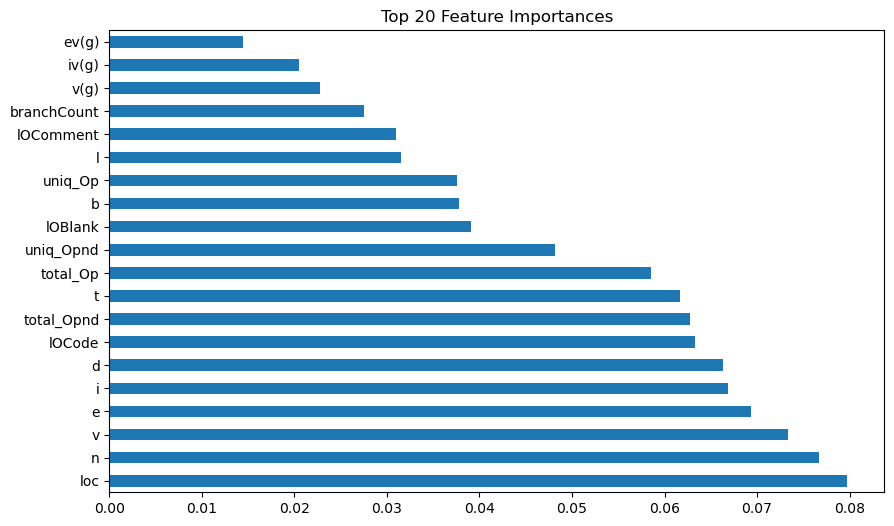

In [2]:
# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
feature_importances.nlargest(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()


In [3]:
# Option 1: Select top 10 features
top_features = feature_importances.nlargest(10).index

# Option 2: Select features above a threshold (e.g., 0.01)
important_features = feature_importances[feature_importances > 0.01].index

# Option 3: Select features until 90% importance is covered
cumulative_importance = feature_importances.sort_values(ascending=False).cumsum()
selected_features = cumulative_importance[cumulative_importance <= 0.90].index

print("Top 10 Features:", top_features)
print("Features with importance > 0.01:", important_features)
print("Features covering 90% importance:", selected_features)


Top 10 Features: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't',
       'total_Op'],
      dtype='object')
Features with importance > 0.01: Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
      dtype='object')
Features covering 90% importance: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't', 'total_Op',
       'uniq_Opnd', 'lOBlank', 'b', 'uniq_Op', 'l'],
      dtype='object')


Top 10 Selected Features: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't',
       'total_Op'],
      dtype='object')


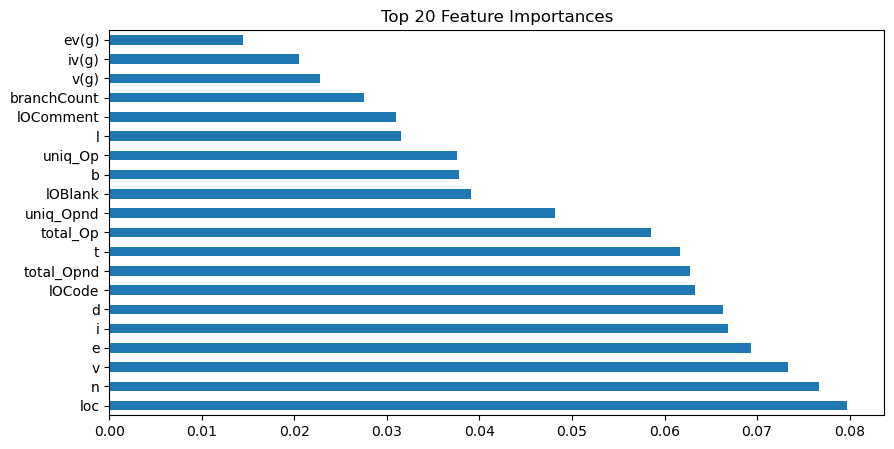

Accuracy with selected features: 0.8578199052132701


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(10).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


Top 10 Selected Features: Index(['loc', 'n', 'v', 'e', 'i', 'd'], dtype='object')


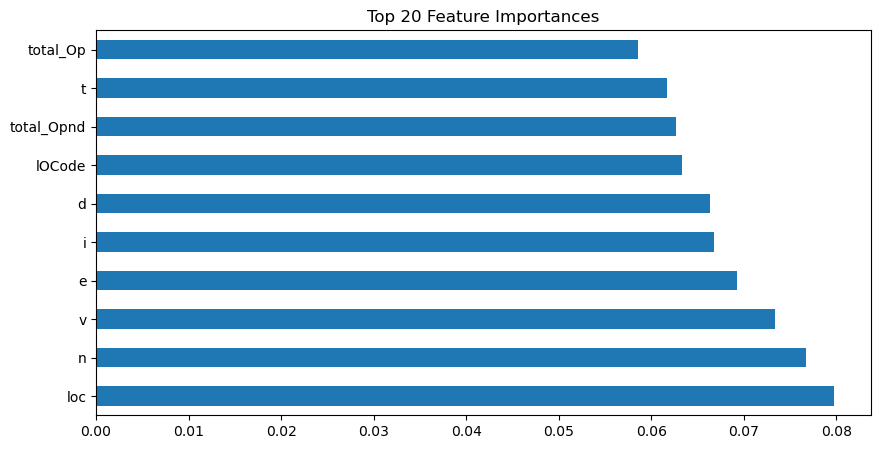

Accuracy with selected features: 0.8672985781990521


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(6).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


Top 10 Selected Features: Index(['loc', 'n', 'v'], dtype='object')


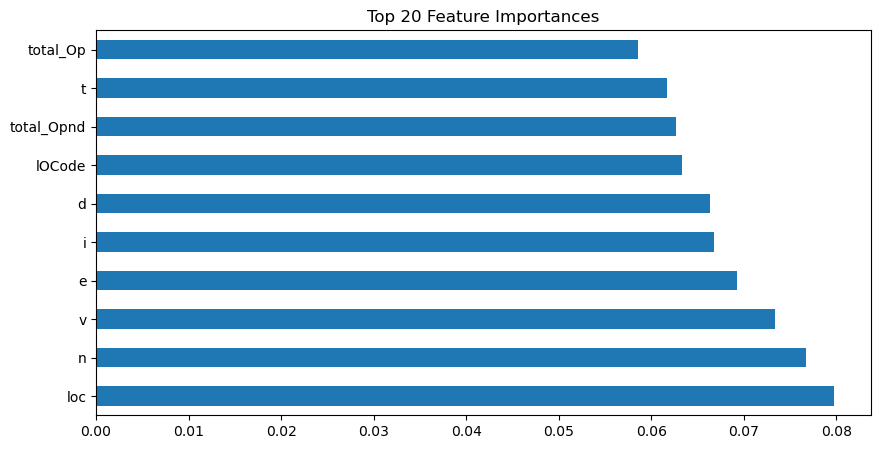

Accuracy with selected features: 0.8530805687203792


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(3).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


Top 10 Selected Features: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't', 'total_Op',
       'uniq_Opnd', 'lOBlank', 'b', 'uniq_Op', 'l', 'lOComment', 'branchCount',
       'v(g)', 'iv(g)', 'ev(g)'],
      dtype='object')


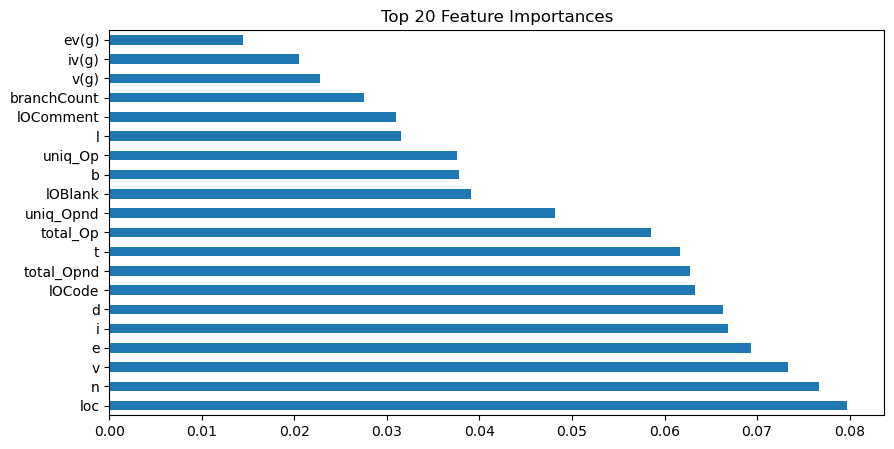

Accuracy with selected features: 0.8767772511848341


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(20).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(20).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


Top 10 Selected Features: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't', 'total_Op',
       'uniq_Opnd', 'lOBlank', 'b', 'uniq_Op', 'l', 'lOComment', 'branchCount',
       'v(g)', 'iv(g)', 'ev(g)', 'locCodeAndComment'],
      dtype='object')


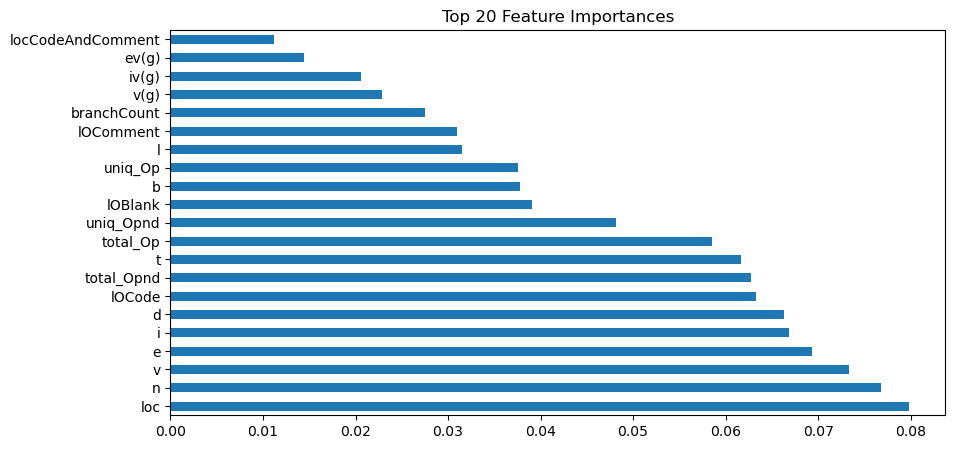

Accuracy with selected features: 0.8744075829383886


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(25).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(25).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


Top 10 Selected Features: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't', 'total_Op',
       'uniq_Opnd', 'lOBlank', 'b', 'uniq_Op', 'l', 'lOComment', 'branchCount',
       'v(g)', 'iv(g)', 'ev(g)', 'locCodeAndComment'],
      dtype='object')


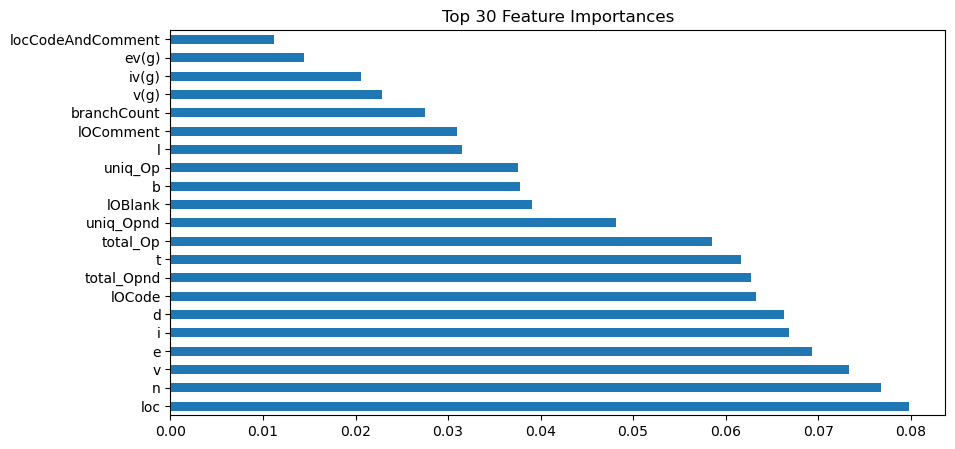

Accuracy with selected features: 0.8744075829383886


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(30).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(30).plot(kind='barh')
plt.title("Top 30 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


Top 10 Selected Features: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't', 'total_Op',
       'uniq_Opnd', 'lOBlank', 'b', 'uniq_Op', 'l'],
      dtype='object')


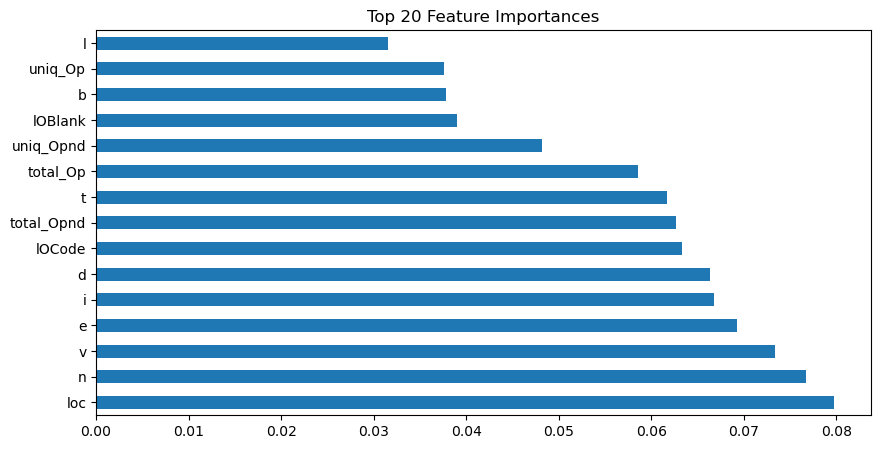

Accuracy with selected features: 0.8601895734597157


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(15).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(15).plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


Top 10 Selected Features: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't', 'total_Op',
       'uniq_Opnd', 'lOBlank', 'b', 'uniq_Op', 'l', 'lOComment', 'branchCount',
       'v(g)', 'iv(g)', 'ev(g)', 'locCodeAndComment'],
      dtype='object')


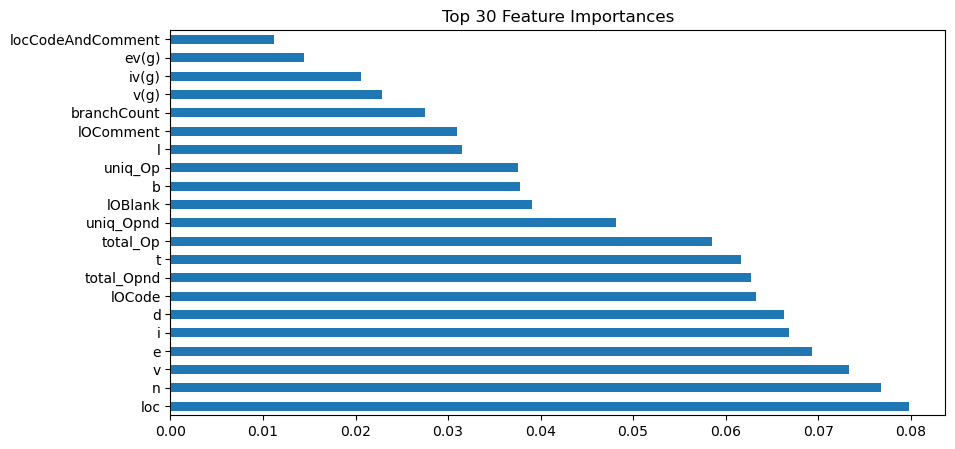

Accuracy with selected features: 0.8744075829383886


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(30).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(35).plot(kind='barh')
plt.title("Top 30 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


Top 10 Selected Features: Index(['loc', 'n', 'v', 'e', 'i', 'd', 'lOCode', 'total_Opnd', 't', 'total_Op',
       'uniq_Opnd', 'lOBlank', 'b', 'uniq_Op', 'l', 'lOComment', 'branchCount',
       'v(g)', 'iv(g)', 'ev(g)', 'locCodeAndComment'],
      dtype='object')


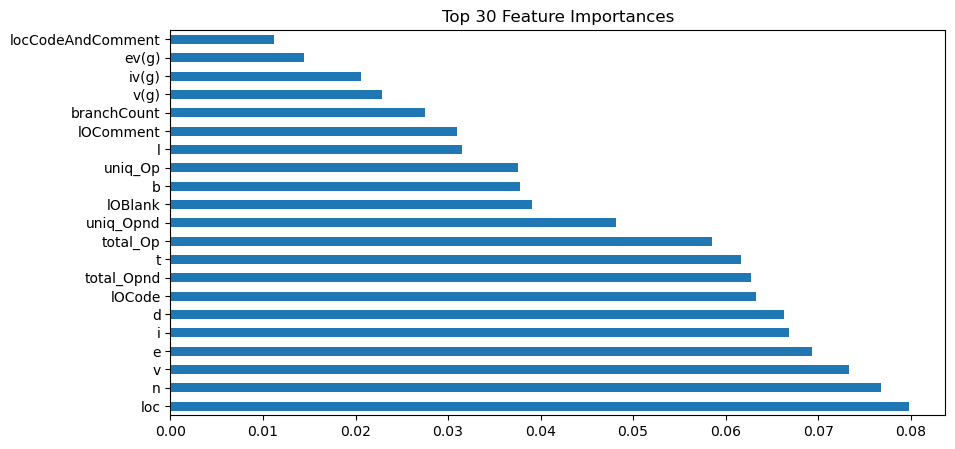

Accuracy with selected features: 0.8720379146919431


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)  # Convert target to integer if necessary

# Split into features and target
X = df.drop(columns=['defects'])
y = df['defects']

# Scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train a Random Forest model to get feature importance
rf_feature_selection = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selection.fit(X_scaled, y)

# Get feature importances
feature_importances = pd.Series(rf_feature_selection.feature_importances_, index=X_scaled.columns)

# Select top 10 features
top_features = feature_importances.nlargest(40).index
X_selected = X_scaled[top_features]

print("Top 10 Selected Features:", top_features)

# Visualize feature importances
plt.figure(figsize=(10, 5))
feature_importances.nlargest(40).plot(kind='barh')
plt.title("Top 30 Feature Importances")
plt.show()

# Train-test split using selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Train a new model using only selected features
rf_selected = RandomForestClassifier(n_estimators=400, max_depth=25, random_state=42)
rf_selected.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_selected.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
import warnings

warnings.filterwarnings("ignore")

# Load and prepare data
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)

X = df.drop(columns=['defects'])
y = df['defects']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Feature selection using Random Forest
rf_feat = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feat.fit(X_scaled, y)
feature_importances = pd.Series(rf_feat.feature_importances_, index=X_scaled.columns)
top_features = feature_importances.nlargest(20).index  # Select top N features
X_selected = X_scaled[top_features]

# Augment data with Gaussian noise
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

X_aug = add_noise(X_selected)
X_combined = pd.concat([X_selected, X_aug], ignore_index=True)
y_combined = pd.concat([y, y], ignore_index=True)

# Helper functions
def apply_smote(X, y):
    smote = SMOTE(sampling_strategy=0.6, random_state=42)
    return smote.fit_resample(X, y)

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    return {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "ROC-AUC": roc_auc_score(y_test, probs)
    }

def get_classifier(class_weight_dict):
    return RandomForestClassifier(n_estimators=200, max_depth=12, class_weight=class_weight_dict, random_state=42)

# Parameters
thresholds = [0.9, 0.85, 0.8]
split_ratios = [0.3, 0.5, 0.7]
table_results = []

for ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=42)
    X_train_labeled, X_unlabeled, y_train_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=(1 - ratio), stratify=y_train, random_state=42)

    X_train_labeled, y_train_labeled = apply_smote(X_train_labeled, y_train_labeled)
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_labeled), y=y_train_labeled)
    clf = get_classifier({0: class_weights[0], 1: class_weights[1]})
    clf.fit(X_train_labeled, y_train_labeled)

    supervised_metrics = evaluate_model(clf, X_test, y_test)
    best_f1, best_metrics, best_threshold = 0, {}, None

    for threshold in thresholds:
        X_train_final = X_train_labeled.copy()
        y_train_final = y_train_labeled.copy()
        X_unlabeled_copy = X_unlabeled.copy()
        patience, max_patience = 0, 3
        prev_f1 = 0

        for _ in range(10):
            probs = clf.predict_proba(X_unlabeled_copy)
            max_probs = np.max(probs, axis=1)
            pseudo_labels = np.argmax(probs, axis=1)
            high_conf_idx = np.where(max_probs >= threshold)[0]

            if len(high_conf_idx) == 0:
                break

            X_train_final = pd.concat([pd.DataFrame(X_train_final, columns=top_features), X_unlabeled_copy.iloc[high_conf_idx]], ignore_index=True)
            y_train_final = np.concatenate((y_train_final, pseudo_labels[high_conf_idx]))

            X_unlabeled_copy = X_unlabeled_copy.drop(X_unlabeled_copy.index[high_conf_idx])
            X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)

            clf.fit(X_train_final, y_train_final)
            current_f1 = f1_score(y_test, clf.predict(X_test))

            if current_f1 <= prev_f1:
                patience += 1
            else:
                patience = 0
                prev_f1 = current_f1

            if patience >= max_patience:
                break

        semi_metrics = evaluate_model(clf, X_test, y_test)
        if semi_metrics["F1"] > best_f1:
            best_f1 = semi_metrics["F1"]
            best_metrics = semi_metrics
            best_threshold = threshold

    table_results.append([
        ratio, len(top_features), *supervised_metrics.values(), best_threshold, *best_metrics.values()
    ])

# Output results
columns = [
    "Labeled Ratio", "Num Features",
    "Supervised Acc", "Supervised Prec", "Supervised Recall", "Supervised F1", "Supervised ROC_AUC",
    "Best Threshold",
    "Semi Acc", "Semi Prec", "Semi Recall", "Semi F1", "Semi ROC_AUC"
]

results_df = pd.DataFrame(table_results, columns=columns)
print("\nFinal Results with Feature Selection:")
print(results_df)

# Save as CSV
results_df.to_csv("final_feature_selection_results.csv", index=False)



Final Results with Feature Selection:
   Labeled Ratio  Num Features  Supervised Acc  Supervised Prec  \
0            0.3            20        0.870853         0.596330   
1            0.5            20        0.876777         0.614035   
2            0.7            20        0.887441         0.640000   

   Supervised Recall  Supervised F1  Supervised ROC_AUC  Best Threshold  \
0           0.500000       0.543933            0.856367            0.90   
1           0.538462       0.573770            0.853092            0.90   
2           0.615385       0.627451            0.891672            0.85   

   Semi Acc  Semi Prec  Semi Recall   Semi F1  Semi ROC_AUC  
0  0.877962   0.626168     0.515385  0.565401      0.861301  
1  0.880332   0.635514     0.523077  0.573840      0.850862  
2  0.887441   0.647059     0.592308  0.618474      0.884691  


In [17]:
top_n_list = [5, 10, 15, 20]
thresholds = [0.9, 0.85, 0.8]
split_ratios = [0.3, 0.5, 0.7]
table_results = []

# Feature importance once on full scaled dataset
rf_feat = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feat.fit(X_scaled, y)
feature_importances = pd.Series(rf_feat.feature_importances_, index=X_scaled.columns)
sorted_features = feature_importances.sort_values(ascending=False)

for top_n in top_n_list:
    selected_features = sorted_features[:top_n].index
    X_selected = X_scaled[selected_features]
    X_aug = add_noise(X_selected)
    X_combined = pd.concat([X_selected, X_aug], ignore_index=True)
    y_combined = pd.concat([y, y], ignore_index=True)

    for ratio in split_ratios:
        X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=42)
        X_train_labeled, X_unlabeled, y_train_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=(1 - ratio), stratify=y_train, random_state=42)

        X_train_labeled, y_train_labeled = apply_smote(X_train_labeled, y_train_labeled)
        class_weights = compute_class_weight("balanced", classes=np.unique(y_train_labeled), y=y_train_labeled)
        clf = get_classifier({0: class_weights[0], 1: class_weights[1]})
        clf.fit(X_train_labeled, y_train_labeled)

        supervised_metrics = evaluate_model(clf, X_test, y_test)
        best_f1, best_metrics, best_threshold = 0, {}, None

        for threshold in thresholds:
            X_train_final = X_train_labeled.copy()
            y_train_final = y_train_labeled.copy()
            X_unlabeled_copy = X_unlabeled.copy()
            patience, max_patience = 0, 3
            prev_f1 = 0

            for _ in range(10):
                probs = clf.predict_proba(X_unlabeled_copy)
                max_probs = np.max(probs, axis=1)
                pseudo_labels = np.argmax(probs, axis=1)
                high_conf_idx = np.where(max_probs >= threshold)[0]

                if len(high_conf_idx) == 0:
                    break

                X_train_final = pd.concat([pd.DataFrame(X_train_final, columns=selected_features), X_unlabeled_copy.iloc[high_conf_idx]], ignore_index=True)
                y_train_final = np.concatenate((y_train_final, pseudo_labels[high_conf_idx]))

                X_unlabeled_copy = X_unlabeled_copy.drop(X_unlabeled_copy.index[high_conf_idx])
                X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)

                clf.fit(X_train_final, y_train_final)
                current_f1 = f1_score(y_test, clf.predict(X_test))

                if current_f1 <= prev_f1:
                    patience += 1
                else:
                    patience = 0
                    prev_f1 = current_f1

                if patience >= max_patience:
                    break

            semi_metrics = evaluate_model(clf, X_test, y_test)
            if semi_metrics["F1"] > best_f1:
                best_f1 = semi_metrics["F1"]
                best_metrics = semi_metrics
                best_threshold = threshold

        table_results.append([
            ratio, top_n, *supervised_metrics.values(), best_threshold, *best_metrics.values()
        ])


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
import warnings

warnings.filterwarnings("ignore")

# Load and prepare data
df = pd.read_csv('kc1.csv')
df.fillna(df.median(), inplace=True)
df['defects'] = df['defects'].astype(int)

X = df.drop(columns=['defects'])
y = df['defects']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Feature selection using Random Forest
rf_feat = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feat.fit(X_scaled, y)
feature_importances = pd.Series(rf_feat.feature_importances_, index=X_scaled.columns)
top_features = feature_importances.nlargest(20).index  # Select top N features
X_selected = X_scaled[top_features]

# Augment data with Gaussian noise
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

X_aug = add_noise(X_selected)
X_combined = pd.concat([X_selected, X_aug], ignore_index=True)
y_combined = pd.concat([y, y], ignore_index=True)

# Helper functions
def apply_smote(X, y):
    smote = SMOTE(sampling_strategy=0.6, random_state=42)
    return smote.fit_resample(X, y)

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    return {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "ROC-AUC": roc_auc_score(y_test, probs)
    }

def get_classifier(class_weight_dict):
    return RandomForestClassifier(n_estimators=200, max_depth=12, class_weight=class_weight_dict, random_state=42)

# Parameters
thresholds = [0.9, 0.85, 0.8]
split_ratios = [0.3, 0.5, 0.7]
table_results = []

for ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, stratify=y_combined, random_state=42)
    X_train_labeled, X_unlabeled, y_train_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=(1 - ratio), stratify=y_train, random_state=42)

    X_train_labeled, y_train_labeled = apply_smote(X_train_labeled, y_train_labeled)
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_labeled), y=y_train_labeled)
    clf = get_classifier({0: class_weights[0], 1: class_weights[1]})
    clf.fit(X_train_labeled, y_train_labeled)

    supervised_metrics = evaluate_model(clf, X_test, y_test)
    best_f1, best_metrics, best_threshold = 0, {}, None

    for threshold in thresholds:
        X_train_final = X_train_labeled.copy()
        y_train_final = y_train_labeled.copy()
        X_unlabeled_copy = X_unlabeled.copy()
        patience, max_patience = 0, 3
        prev_f1 = 0

        for _ in range(10):
            probs = clf.predict_proba(X_unlabeled_copy)
            max_probs = np.max(probs, axis=1)
            pseudo_labels = np.argmax(probs, axis=1)
            high_conf_idx = np.where(max_probs >= threshold)[0]

            if len(high_conf_idx) == 0:
                break

            X_train_final = pd.concat([pd.DataFrame(X_train_final, columns=top_features), X_unlabeled_copy.iloc[high_conf_idx]], ignore_index=True)
            y_train_final = np.concatenate((y_train_final, pseudo_labels[high_conf_idx]))

            X_unlabeled_copy = X_unlabeled_copy.drop(X_unlabeled_copy.index[high_conf_idx])
            X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)

            clf.fit(X_train_final, y_train_final)
            current_f1 = f1_score(y_test, clf.predict(X_test))

            if current_f1 <= prev_f1:
                patience += 1
            else:
                patience = 0
                prev_f1 = current_f1

            if patience >= max_patience:
                break

        semi_metrics = evaluate_model(clf, X_test, y_test)
        if semi_metrics["F1"] > best_f1:
            best_f1 = semi_metrics["F1"]
            best_metrics = semi_metrics
            best_threshold = threshold

    table_results.append([
        ratio, len(top_features), *supervised_metrics.values(), best_threshold, *best_metrics.values()
    ])

# Output results
columns = [
    "Labeled Ratio", "Num Features",
    "Supervised Acc", "Supervised Prec", "Supervised Recall", "Supervised F1", "Supervised ROC_AUC",
    "Best Threshold",
    "Semi Acc", "Semi Prec", "Semi Recall", "Semi F1", "Semi ROC_AUC"
]

results_df = pd.DataFrame(table_results, columns=columns)
print("\nFinal Results with Feature Selection:")
print(results_df)

# Save as CSV
# results_df.to_csv("final_feature_selection_results.csv", index=False)



Final Results with Feature Selection:
   Labeled Ratio  Num Features  Supervised Acc  Supervised Prec  \
0            0.3            20        0.870853         0.594595   
1            0.5            20        0.881517         0.636364   
2            0.7            20        0.887441         0.649573   

   Supervised Recall  Supervised F1  Supervised ROC_AUC  Best Threshold  \
0           0.507692       0.547718            0.857897             0.9   
1           0.538462       0.583333            0.858005             0.9   
2           0.584615       0.615385            0.887600             0.9   

   Semi Acc  Semi Prec  Semi Recall   Semi F1  Semi ROC_AUC  
0  0.877962   0.631068     0.500000  0.557940      0.854708  
1  0.877962   0.615385     0.553846  0.582996      0.847851  
2  0.898104   0.689655     0.615385  0.650407      0.886533  
